In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
direccion= "../Data/properati5.csv"
data_original=pd.read_csv(direccion, sep=',')
print(data_original.shape)
print(data_original.columns)
data_original.head(3)

(121220, 26)
Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...


#### Análisis general 
Se crean funciones para haer un análisis general del dataset:

In [3]:
def data_creacion(data_original):
    #nulls por fila original
    data_original["null_fila"]=data_original.isnull().sum(axis=1)
    
    #nulls por fila
    campos_ignorar= ["floor","rooms","expenses","geonames_id","lat-lon","lat","lon"]
    data_pocos_campos_nulos=data_original.drop(campos_ignorar,axis=1)
    data_pocos_campos_nulos["null_fila"]=data_pocos_campos_nulos.isnull().sum(axis=1)

    #categoricas - numericas
    columnas_categorica=data_original.select_dtypes(include="object").columns
    data_categorica=data_original.loc[:,columnas_categorica]
    data_numerica=data_original.drop(columnas_categorica,axis=1)
    
    return data_categorica,data_numerica,data_pocos_campos_nulos


In [4]:
data_categorica,data_numerica,data_pocos_campos_nulos=data_creacion(data_original)


Se observan los nulos en las *columnas* para tratar de analizar que datos es posible imputar y que columnas se deberán eliminar.

In [5]:
# Nulls Columnas
data_original.isnull().sum()*100/data_original.shape[0]


Unnamed: 0                     0.000000
operation                      0.000000
property_type                  0.000000
place_name                     0.018974
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   15.440521
lat-lon                       42.525986
lat                           42.525986
lon                           42.525986
price                         16.837156
currency                      16.837981
price_aprox_local_currency    16.837156
price_aprox_usd               16.837156
surface_total_in_m2           32.443491
surface_covered_in_m2         16.422208
price_usd_per_m2              43.394654
price_per_m2                  27.686850
floor                         93.483749
rooms                         60.905791
expenses                      88.234615
properati_url                  0.000000
description                    0.001650
title                          0.000000


#### Duplicados

En primer lugar se analiza si hay registros *duplicados*. Se examinan los registros que comparten los valores en las columnas **state_name**, **place_name**, **title**, **surface_total_in_m2**, **description**, **price_usd_per_m2** e **image_thumbnail**. Dado que es posible que en un mismo edificio haya publicaciones similares en los casos de desarrollos inmobiliarios (pozo), se define analizar por un lado los registros donde la columna **propery_type** no sea "aparment" y por el otro, en el caso de los registros de "apartment", se observará si corresponden o no a la misma propiedad a traves de la revisión de **descripcion** y **título**. 

In [6]:
contador_busqueda_mask= data_original.duplicated(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")
contador_busqueda=data_original.loc[contador_busqueda_mask]
no_apartament=contador_busqueda.property_type!="apartment"
no_apartamentm=contador_busqueda[no_apartament]
no_apartamentm.shape

(172, 27)

In [7]:
contador_busqueda_mask= data_original.duplicated(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")
contador_busqueda=data_original.loc[contador_busqueda_mask]
apartmentmask=contador_busqueda.property_type=="apartment"
apartment=contador_busqueda[apartmentmask]
apartment.shape

(1551, 27)

In [8]:
apartment["title"].head(10)

245    Departamentos monoambiente, zona parque Indepe...
247    Departamentos monoambiente, zona parque Indepe...
248    Departamentos monoambiente, zona parque Indepe...
249    Departamentos monoambiente, zona parque Indepe...
250    Departamentos monoambiente, zona parque Indepe...
959           Departamento en Venta ubicado en Chacarita
960           Departamento en Venta ubicado en Chacarita
970           Departamento en Venta ubicado en Chacarita
971           Departamento en Venta ubicado en Chacarita
972           Departamento en Venta ubicado en Chacarita
Name: title, dtype: object

In [9]:
apartment["description"].head(10)

245    Departamento de un ambiente al contrafrente co...
247    Departamento de un ambiente al contrafrente co...
248    Departamento de un ambiente al contrafrente co...
249    Departamento de un ambiente al contrafrente co...
250    Departamento de un ambiente al contrafrente co...
959    Venta - Departamento - Argentina, Buenos Aires...
960    Venta - Departamento - Argentina, Buenos Aires...
970    Venta - Departamento - Argentina, Buenos Aires...
971    Venta - Departamento - Argentina, Buenos Aires...
972    Venta - Departamento - Argentina, Buenos Aires...
Name: description, dtype: object

Conlcuimos que no se podía determinar si corresponden a desarrollos inmobiliarios, por lo cual se define eliminar los duplicados considerando como tales a los registros que tengan los mismos valores en las columnas **state_name**, **place_name**, **title**, **surface_total_in_m2**, **description**, **price_usd_per_m2** e **image_thumbnail**.

In [10]:
data_original= data_original.drop_duplicates(["state_name","place_name","title","surface_total_in_m2","description","price_usd_per_m2","image_thumbnail"],keep="first")

#### Columas "floor" y "expenses"

Las columnas **"floor"** y **"expenses"** tienen un porcentaje muy importante de nulos. Se analiza si los nulos corresponden a los registros que no son apartment, en cuyo caso sería correcto que estén vacíos.&nbsp;


Se observa que en "apartment" también es muy alto el porcentaje de nulos por lo que se define eliminar la columna (será realizado al finalizar la limpieza de datos).



In [11]:
mask_apart = data_original["property_type"] =="apartment"
data_apart = data_original.loc[mask_apart, :]
data_apart.isnull().sum()*100/data_apart.shape[0]

Unnamed: 0                     0.000000
operation                      0.000000
property_type                  0.000000
place_name                     0.001439
place_with_parent_names        0.000000
country_name                   0.000000
state_name                     0.000000
geonames_id                   12.361539
lat-lon                       40.896798
lat                           40.896798
lon                           40.896798
price                         15.327848
currency                      15.327848
price_aprox_local_currency    15.327848
price_aprox_usd               15.327848
surface_total_in_m2           27.749806
surface_covered_in_m2         15.619875
price_usd_per_m2              38.661277
price_per_m2                  25.898380
floor                         90.637857
rooms                         55.535576
expenses                      84.019047
properati_url                  0.000000
description                    0.002877
title                          0.000000


#### Columna "rooms"

Se observan muchos nulos en la columna **"rooms"**, se intentará recuperar esta infomación a través de la búsqueda con expresiones regulares en **description** de "Ambientes" y "Habitaciones (sabiendo que no son sinonimos con el fin de conocer con qué información se cuenta). Se generan nuevas columnas con estos valores y se evalúa la cantidad de nulos. 

In [12]:
def patron_ambientes(data, patron):
    patron_ambientes = patron
    regex = re.compile(patron_ambientes, flags= re.IGNORECASE)
    ambientes_descripcion = data["description"].apply(lambda x:None if x is np.NaN else regex.search(x))
    return ambientes_descripcion

In [13]:
ambientes_descripcion = patron_ambientes(data_original, "(?P<cantidad_ambientes>\d+)\s*amb\D*")

print(ambientes_descripcion.notnull().sum())

37742


In [14]:
cantidad_ambientes_descripcion = ambientes_descripcion.apply(lambda x: x if x is None else x.group("cantidad_ambientes"))
rooms=data_original["rooms"]

In [15]:
#Agregamos la cantidad de ambientes definida en la descrpición a la columna rooms y analizamos la cantidad de nulos

ambientes = rooms.combine_first(cantidad_ambientes_descripcion)
print("porcentaje de nulos: ", ambientes.isnull().sum()*100/ambientes.shape)

porcentaje de nulos:  [44.74338268]


In [16]:
#Agregamos la cantidad de habitaciones definida en la descrpición a la columna rooms y analizamos la cantidad de nulos:

habitaciones_descripcion = patron_ambientes(data_original, "(?P<habitaciones>\d+)\s*habitacion\D*")
print(habitaciones_descripcion.notnull().sum())

2749


In [17]:
cantidad_habitacioness_descripcion = habitaciones_descripcion.apply(lambda x: x if x is None else x.group("habitaciones"))
ambientes_hab = ambientes.combine_first(cantidad_habitacioness_descripcion)
print("porcentaje de nulos: ", ambientes_hab.isnull().sum()*100/ambientes.shape)

porcentaje de nulos:  [43.74252073]


Dado que el procentaje de información nula es muy alta, se define eliminar la columna **rooms** (será realizado al finalizar la limpieza de datos).

#### Ubicación

Se define qué variables utilizar para la ubicación de la propiedad.&nbsp;

Hay 4 columnas en el dataset:&nbsp;

**country_name**: Corresponde al país, en todos los casos el valor es "Argentina".&nbsp;

**state_name**: Corresponde a las provincias y se encuentra completa.&nbsp;

**place_with_parent_names**: Está formada por distintos valores separados por "|", país, provincia, localidad (o barrio en Capital Federal) y barrio.&nbsp;

**place_name**: Corresponde al último registro de "place_with_parents_names", dependiendo el caso se refiere a la provincia, la localidad o el barrio.&nbsp;

Se realizará un análisis de cada una.


La columna **country_name** tiene en todos los registros el mismo valor: "Argentina", por lo que se define eliminar esta columna (será realizado al finalizar la limpieza de datos)

In [18]:
data_original["country_name"].value_counts()

Argentina    119497
Name: country_name, dtype: int64

En la columna **state_name** se observa que "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Buenos Aires Interior", "Capital Federal", "Córdoba" y "Santa Fe" representan el 94.06% del dataset.
Respecto de las otras provincias se observan poca cantidad de datos.


In [19]:
data_prov = data_original.groupby("state_name")
print(data_prov.size())
print(data_prov.size()*100/121220)


state_name
Bs.As. G.B.A. Zona Norte        25293
Bs.As. G.B.A. Zona Oeste         9304
Bs.As. G.B.A. Zona Sur          13863
Buenos Aires Costa Atlántica     9955
Buenos Aires Interior            2278
Capital Federal                 31661
Catamarca                          27
Chaco                              57
Chubut                            259
Corrientes                        582
Córdoba                         11796
Entre Ríos                        369
Formosa                            65
Jujuy                              26
La Pampa                          155
La Rioja                            4
Mendoza                           677
Misiones                          457
Neuquén                           713
Río Negro                         804
Salta                             276
San Juan                           40
San Luis                          246
Santa Cruz                         20
Santa Fe                         9866
Santiago Del Estero                 4
T

Respecto de la columna **place_name** se observan 23 datos nulos. Se puede observar a través de los valores de la columna **place_with_parent_names** que corresponden a Tigre. Por lo que se define imputar esos valores

In [20]:
print(data_original["place_name"].isnull().sum())
data_original.loc[(data_original["place_name"].isnull()), :]

23


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila
6489,6489,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4008968545,-58.63809847",-34.400897,...,2708.333333,2708.333333,NaN,NaN,NaN,http://www.properati.com.ar/15ui7_venta_casa_t...,"Espectacular casa moderna de una planta, con a...",Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/7/vQjgbHSz1fKXxy...,5
10201,10201,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.400704,-58.638067",-34.400704,...,NaN,1783.333333,NaN,5.0,NaN,http://www.properati.com.ar/166p5_venta_casa_t...,Corredor Responsable: SABRINA COCCONI - CSI 62...,VENTA CASA SANTA MARÍA DE TIGRE COUNTRY BARRIO...,https://thumbs4.properati.com/1/FABpKIJMaoAO3t...,6
11451,11451,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4026880384,-58.6262613379",-34.402688,...,253.456221,2037.037037,NaN,NaN,NaN,http://www.properati.com.ar/16bpd_venta_casa_t...,MUY LINDA CASA EN EXCELENTE UBICACION!! Superf...,SANTA MARIA DE TIGRE IMPECABLE,https://thumbs4.properati.com/5/fwH9L71hW2rW7V...,5
14839,14839,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4007994779,-58.6381735719",-34.400799,...,2000.000000,2400.000000,NaN,NaN,NaN,http://www.properati.com.ar/16tal_venta_casa_b...,Muy linda casa de estilo clásico.-Planta baja;...,Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/1/3ZbPSffTY38y7v...,5
18622,18622,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4032781195,-58.6263503945",-34.403278,...,3814.705882,3814.705882,NaN,NaN,NaN,http://www.properati.com.ar/177ee_venta_casa_t...,Casa con increible vista al lago con playa de...,Casa con increible vista al lago con playa y m...,https://thumbs4.properati.com/0/52JCH1PKYCOMe6...,5
21922,21922,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.399704,-58.638405",-34.399704,...,NaN,2000.000000,NaN,5.0,NaN,http://www.properati.com.ar/17gy5_venta_casa_s...,Corredor Responsable: Matias Castelli - CUCICB...,Venta Casa - Barrio Santa Maria de Tigre,https://thumbs4.properati.com/8/oO7kmFPYNm8DYr...,6
23664,23664,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4005161998,-58.6417999185",-34.400516,...,1632.653061,1632.653061,NaN,NaN,NaN,http://www.properati.com.ar/17mb5_venta_casa_t...,EXCELENTE CASA CLASICA con grandes ventanas y ...,CASA EN VENTA EN SANTA MARIA DE TIGRE CON RENTA,https://thumbs4.properati.com/2/LQCwH6txpFqetn...,5
24722,24722,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.4007292,-58.6377783",-34.400729,...,1677.215190,1962.962963,NaN,NaN,NaN,http://www.properati.com.ar/17oz1_venta_casa_t...,"EN EXCLUSIVIDAD!!!!!!Lindísima casa, muy lumin...",Venta de casa en Santa María de Tigre,https://thumbs4.properati.com/0/Nhx4NejZaQACap...,5
38856,38856,sell,house,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.425087,-58.5796585",-34.425087,...,NaN,2454.545455,NaN,NaN,NaN,http://www.properati.com.ar/18mcb_venta_casa_t...,SANTA MARIA DE TIGRE- AL RIO - ESPECTACULAR CA...,"Casa (barrio cerrado), Venta",https://thumbs4.properati.com/2/Izq8d5o8ti3kJy...,7
45970,45970,sell,apartment,NaN,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre||,Argentina,Bs.As. G.B.A. Zona Norte,NaN,"-34.396074,-58.63738",-34.396074,...,1727.272727,3518.518519,NaN,1.0,NaN,http://www.properati.com.ar/1958f_venta_depart...,"EDIFICIO ZERENA – EL PALMAR, NORDELTA. Torre 2...",Excelente monoambiente. Barrio El Palmar. Con...,https://thumbs

Se completa la columna reemplazando los valores nulos en una Series (para que no reemplace los nulos en todo el dataset) y se realiza un join de la nueva columna llamada: **place_name_completo**. Se elimina la columna **place name**.

In [21]:
place_name = data_original["place_name"]
ubicacion = place_name.replace(np.NaN, "Tigre")
data_ubicacion = data_original.join(ubicacion, rsuffix='_completo')

In [22]:
data_ubicacion=data_ubicacion.drop(columns = "place_name",axis=1)

In [23]:
data_ubicacion.head(3)

,Unnamed: 0,operation,property_type,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila,place_name_completo
0,0,sell,PH,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,...,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,3,Mataderos
1,1,sell,apartment,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,...,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,7,La Plata
2,2,sell,apartment,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,...,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,3,Mataderos


La columna **place_with_parents_names** está compuesta por distintos valores, se crea una función para identificar cada uno con expresiones regulares. Se recupera la 3er columna que corresponde a la localidad (el barrio en el caso de Capital Federal). Este valor en algunos casos coincidirá con **place_name** (cuando no haya exista el 4to valor correspondiente al barrio). &nbsp;

Se utilizará para los análisis la localidad debido a que **place_name** tiene distintos grados de agregación, y en algunos casos es demasiado espefíca.

In [24]:
def dividir_columna(data):
    patron_columna =patron_columna ="^(\|)(?P<pais>Argentina)(\|)(?P<provincia>[\w\s\.]+)(\|)(?P<localidad>[\w\s\./-]+)(\|)(?P<barrio>[\w\s\./-]*)(\|?)"
    regex_place = re.compile(patron_columna)
    columnas = data["place_with_parent_names"].apply(lambda x: regex_place.search(x))
    localidad = columnas.apply(lambda x: x if x is None else x.group("localidad"))
    return localidad


In [25]:
localidad = dividir_columna(data_ubicacion)

Se realiza un join y se incorpora **place_wiht_parents_name_localidad** con el 3er valor de la columna **place_with_parent_names** y se elimina **place_with_parent_names** 

In [26]:
data_localidad = data_ubicacion.join(localidad, rsuffix='_localidad')

In [27]:
data_localidad=data_localidad.drop(columns = "place_with_parent_names",axis=1)

data_localidad.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,floor,rooms,expenses,properati_url,description,title,image_thumbnail,null_fila,place_name_completo,place_with_parent_names_localidad
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...,3,Mataderos,Mataderos
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...,7,La Plata,La Plata
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...,3,Mataderos,Mataderos


Se observa que hay 4476 valores nulos en **place_with_parents_name_localidad** que corresponden a los registros que solo tenían dos datos en **place_with_parents_names** (país y provincia), debido a esto en la columna **place_name** se encuentra el dato de provincia. Se analiza si es posible imputar la localidad en base a **description** o **title**.

In [28]:
print(data_localidad["place_with_parent_names_localidad"].isnull().sum())
nulos_localidad = data_localidad[data_localidad["place_with_parent_names_localidad"].isnull()]

#Se observan cuántos nulos hay en cada provincia para ver buscar posibles imputaciones
nulos_localidad["state_name"].value_counts()

4476


Córdoba                         2557
Capital Federal                 1095
Bs.As. G.B.A. Zona Norte         222
Mendoza                          128
Buenos Aires Interior            106
Tucumán                           76
Bs.As. G.B.A. Zona Oeste          65
Misiones                          42
Santa Fe                          32
Buenos Aires Costa Atlántica      27
Bs.As. G.B.A. Zona Sur            24
Salta                             21
San Luis                          19
Chubut                            17
Neuquén                           10
Río Negro                          8
San Juan                           7
Tierra Del Fuego                   6
Catamarca                          3
Santiago Del Estero                3
La Pampa                           3
Corrientes                         2
La Rioja                           1
Jujuy                              1
Chaco                              1
Name: state_name, dtype: int64

In [29]:
#Se prueba buscando en la Capital Federal
#A primera vista se observa por "title" y "description" que no todos las propiedades son efectivamente de Capital Federal

data_capital_federal = nulos_localidad.loc[(nulos_localidad["state_name"]=="Capital Federal"), :]
data_capital_federal.title.head(10)

108    Casa 180m² con 2 Plantas en Navarro, Julián 29...
110    Casa 744m² con 2 Plantas en Del Valle Iberluce...
115    Casa 720m² con Plantas en Palma, Diego 1800, A...
119    Casa 200m² con Cochera en Barbosa, Gerónimo 14...
121    Casa 340m² con Cochera en Palma, Diego 1300, A...
311    Casa 741m² con 2 Plantas, Argentina, Capital F...
315    Casa 160m² con 3 Plantas en Marconi, Ing. 2400...
316    Casa 125m² con 3 Plantas en Lezica, Martín 300...
317    Casa 125m² con 3 Plantas en Lezica, Martín 300...
326    Casa 1050m² con 3 Plantas, Argentina, Capital ...
Name: title, dtype: object

Se intenta buscando barrios para ver si es posible imputar los valores de "ubicacion" a través de **description**.

In [30]:
def imputar_barrio(data, patron):
    patron_barrio = patron
    regex_barrio = re.compile(patron_barrio, flags=re.IGNORECASE)
    barrio_search = data["description"].apply(lambda x: None if x is np.NaN else regex_barrio.search(x))
    barrio = barrio_search.apply(lambda x: x if x is None else x.group(0))
    return barrio
    
data_villa_crespo = imputar_barrio(data_capital_federal, "Villa Crespo")


In [31]:
mask_villa_crespo = data_villa_crespo.notnull()
villa_crespo = data_capital_federal.loc[mask_villa_crespo, :]
villa_crespo["description"].value_counts()

#Se observa que aunque aparece Villa Crespo en la descripción, se refiere a la ubicación de la inmobiliaria, por lo que no es una buena manera de imputar los barrios

Este emprendimiento está ubicado en pleno barrio de Villa Crespo, único lote en esquina de 1.800m2 con excelentes vistas a la ciudad. El edificio de 12 pisos contará con departamentos de 1, 2, 3 y 4 ambientes, y excelentes amenties que le brindarán un espacio de recreación y confort inigualable.                                                   1
Casa de 3 amb con living comedor, baño y toilette. Con terraza y cochera. sup total: 160 m2. En el Barrio Villa General Mitre en cercanía del metrobus.U$D 300.000Grupo Mega Op. ScalabriniTel: Av Scalabrini Ortiz 393 - Villa Crespo. CABA                                                                                                               1
Venta de local en galeria, en el barrio de Microcentro, muy buena ubicación.Superficie total y cubierta de 23 m2.Tiene un entrepiso, actualmente funciona una libreria.Posee teléfono de línea, expensas $600.Consultar por venta de local + fondo de comercio.Grupo Mega Op. ScalabriniTel: Av Scalabrini Ort

In [32]:
#Se prueba busando una localidad:

data_san_bernardo = imputar_barrio(nulos_localidad, "san bernardo")

print(data_san_bernardo.notnull().sum())
mask_san_bernardo = data_san_bernardo.notnull()
san_bernardo = nulos_localidad.loc[mask_san_bernardo, :]
san_bernardo["description"].value_counts().tail(5)

#Se observa que "San Bernardo" también lo encuentra como barrio de la localidad de Luján.

13


Duplex en San Berdardo ;  en pleno centro , a 4 cuadras del mar y 6 de Av. San Bernardo.Al Contado u$s 25.000 y 25  cuotas de u$s 2000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Se concluye que no es posible imputar los valores nulos en **place_with_parent_names_localidad** ya que no es confiable la información (tampoco es posible confirmar a qué provincia pertenece). Debido a esto se eliminan los registros.

In [33]:
def elimino_filas(data, columna):
    data_completa=data.dropna(subset=[columna], axis=0)
    return data_completa

data_completa = elimino_filas(data_localidad, "place_with_parent_names_localidad")

#Revisamos que este bien realizada la operación:
print(data_completa.place_with_parent_names_localidad.isnull().sum())
print(data_localidad.shape)
print(data_completa.shape)
print(119497-115021)
#La diferencia son los 4476 registros de localidad vacios

0
(119497, 27)
(115021, 27)
4476


In [34]:
data_completa["provincia_localidad"]=data_completa["state_name"]+"_"+data_completa["place_with_parent_names_localidad"]

C:\Users\Usuario\anaconda3\envs\dhdsblend\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
data_completa["provincia_localidad"]

0                          Capital Federal_Mataderos
1                    Bs.As. G.B.A. Zona Sur_La Plata
2                          Capital Federal_Mataderos
3                            Capital Federal_Liniers
4         Buenos Aires Costa Atlántica_Mar del Plata
                             ...                    
121214           Bs.As. G.B.A. Zona Norte_San Isidro
121215                      Capital Federal_Belgrano
121216           Bs.As. G.B.A. Zona Norte_San Isidro
121217                 Capital Federal_Villa Urquiza
121218    Buenos Aires Costa Atlántica_Mar del Plata
Name: provincia_localidad, Length: 115021, dtype: object

#### Precio

Por otro lado es necesario analizar el precio. Observamos las siguientes columnas: 
**price_aprox_local_currency**,
**price_aprox_usd**,
**price_usd_per_m2**( corresponde al precio por m2 total), **price_per_m2** (corresponde al precio por m2 cubierto)



In [36]:
print("nulos de precio en $", data_completa["price_aprox_local_currency"].isnull().sum())
print("nulos de precio en U$D", data_completa["price_aprox_usd"].isnull().sum())
print("nulos de precio en U$D por m2", data_completa["price_usd_per_m2"].isnull().sum())
print("nulos de precio en U$D por m2", data_completa["price_per_m2"].isnull().sum())


nulos de precio en $ 18736
nulos de precio en U$D 18736
nulos de precio en U$D por m2 49098
nulos de precio en U$D por m2 30975


El tipo de cambio utilizado en la base es 17.6445 que corresponde al año del dataset. Se utilizarán los valores de precio en USD y se eliminará la columna **price_aprox_local_currency** (será realizado al finalizar la limpieza de datos). 


In [37]:
tipo_de_cambio = data_completa["price_aprox_local_currency"]/data_completa["price_aprox_usd"]
tipo_de_cambio[0]

17.6445

En virtud de la variedad de datos y la falta de información se definió que la mejor manera de realizar los análisis eran a partir del precio por m2 total de cada propiedad. En ese sentido se definió imputar **price_usd_per_m2** tomando en cuenta **"provincia_localidad"** y **propery_type**. &nbsp;

En primer lugar, se observa que hay valores de **provincia_localidad** con pocos registros. Además al agruparlo por **propery_type** muchos grupos no cuentan con suficientes cantidad de registros para poder realizar la imputación de una manera confiable. Debido a esto se define utilizar solamente los agrupamientos que tengan 5 o más registros. 

In [38]:
cant_por_grupo = data_completa.groupby(by=["provincia_localidad", "property_type"]).agg(cantidad_por_grupo=("Unnamed: 0", "count"))
data_con_cant =pd.merge(data_completa, cant_por_grupo, left_on=["provincia_localidad",'property_type'], right_index=True, how='left')
data_hasta_5=data_con_cant.loc[(data_con_cant["cantidad_por_grupo"]>=5),:]

print(data_completa.shape)
print(data_hasta_5.shape)

#revisamos la operación
agrupado = data_hasta_5.groupby(by=["provincia_localidad", "property_type"])
agrupado["Unnamed: 0"].count().sort_values()
#Se eliminan 939 registros

(115021, 28)
(114082, 29)


provincia_localidad                         property_type
Mendoza_El Sauce                            house               5
Salta_Salta                                 PH                  5
Salta_Rosario de Lerma                      house               5
Buenos Aires Interior_General Alvarado      house               5
Salta_Cafayate                              apartment           5
                                                             ... 
Córdoba_Córdoba                             apartment        3789
Bs.As. G.B.A. Zona Norte_Tigre              apartment        4053
                                            house            4804
Buenos Aires Costa Atlántica_Mar del Plata  apartment        5341
Santa Fe_Rosario                            apartment        7140
Name: Unnamed: 0, Length: 628, dtype: int64

Se resolvió eliminar los valores de **price_usd_per_m2** considerados outliers previo a realizar la imputación para no evitar una imputación errórea que distrorsione el dataset.

In [39]:
q1=data_hasta_5["price_usd_per_m2"].quantile(0.25)
q2 = data_hasta_5["price_usd_per_m2"].quantile(0.5)
q3= data_hasta_5["price_usd_per_m2"].quantile(0.75)
q4 = data_hasta_5["price_usd_per_m2"].quantile(1)
interq=q3-q1

umbral_bajo = q1 - (1.5*interq)
umbral_alto = q3 + (1.5*interq)


outlier_alto = data_hasta_5["price_usd_per_m2"] > umbral_alto
outlier_bajo = data_hasta_5["price_usd_per_m2"] < umbral_bajo
outlier_mask = np.logical_or(outlier_alto , outlier_bajo )
sin_outliers = np.logical_not(outlier_mask)
outliers = data_hasta_5["price_usd_per_m2"][outlier_mask]
print(umbral_alto)

data_limpia=data_hasta_5[sin_outliers]
print("Se eliminan:", data_hasta_5.shape[0] - data_limpia.shape[0])

4400.0
Se eliminan: 2752


Se genera una función a fin de analizar los valores por ubicacion y **property_type** para poder imputar los precios. 

In [40]:
def generar_campos_para_imputar(data, columna):
    precio_m2_prom = data.groupby(by=[columna,"property_type"]).agg(price_m2_prom=("price_usd_per_m2","mean"))
    desvio_por_grupo = data.groupby(by=[columna,"property_type"]).agg(price_m2_desv=("price_usd_per_m2","std"))
    cant_por_grupo = data.groupby(by=[columna,"property_type"]).agg(cant=("price_usd_per_m2",'count'))
    q1_por_grupo = data.groupby(by=[columna,"property_type"])["price_usd_per_m2"].quantile(0.25).to_frame("q1")
    q3_por_grupo = data.groupby(by=[columna,"property_type"])["price_usd_per_m2"].quantile(0.75).to_frame("q3")
    data_con_campo_a_imputar = pd.merge(data, precio_m2_prom, left_on=[columna,'property_type'], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, desvio_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar["coef_var"] = data_con_campo_a_imputar["price_m2_desv"]/data_con_campo_a_imputar["price_m2_prom"]
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, cant_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, q1_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    data_con_campo_a_imputar = pd.merge(data_con_campo_a_imputar, q3_por_grupo, left_on=[columna,"property_type"], right_index=True, how="left")
    return data_con_campo_a_imputar

Se crea una función para poder estimar **precio_usd_per_m2** en los casos que se cuente con la información de **price_usd_per_m2"

In [41]:
def completar_datos_para_estimar(data):
    precios_m2_imputados=data.apply(
        lambda x: x["price_aprox_usd"] / x["surface_total_in_m2"] 
                if pd.isnull(x["price_usd_per_m2"]) and  x["surface_total_in_m2"]>0
                else x["price_usd_per_m2"]  , axis=1) 
    data_original["price_usd_per_m2"]=precios_m2_imputados
    return datos_para_imputar

Se crea una función para eliminar los outliers en el campo **price_usd_per_m2**.

In [42]:
def eliminar_outliers(data):
    outlier_alto = (data["price_usd_per_m2"]>(data["q3"]+1.5*(data["q3"]-data["q1"])))
    outlier_bajo = (data["price_usd_per_m2"]<(data["q1"]-1.5*(data["q3"]-data["q1"])))
    outlier_mask = np.logical_or(outlier_alto , outlier_bajo )
    sin_outliers = np.logical_not(outlier_mask)
    datos_sin_outliers=data.drop(data[outlier_mask].index)  
    return datos_sin_outliers 

Se crea una función para imputar los valores de **price_usd_per_m2** tomando como criterio que el coeficiente de variación (considerando la ubicación y **propery_type** sea menor a 0.8.

In [43]:
def imputar_valores(data):
    precios_m2_imputados=data.apply(
        lambda x: x["price_m2_prom"] 
                if pd.isnull(x["price_usd_per_m2"]) and x["coef_var"]<0.8
                else x["price_usd_per_m2"]  , axis=1)   
    data["price_usd_per_m2"]=precios_m2_imputados
    return data
   

Se crea una función para eliminar todos los datos nulos que no se han podido imputar.

In [44]:
def eliminar_precio_nan(data):
    #analizo el caso de eliminar los precio NaN, en lugar de estimarlos
    sin_precio_nulo=data.dropna(subset=["price_usd_per_m2"]) 
    return sin_precio_nulo

Se realizan las imputaciones y se eliminan los datos utilizando como ubicación la columna **"provincia_localidad"** obsevando en cada caso los nulos y tamaños de cada dataset para confirmar que los pasos se realicen correctamente.

In [45]:
print("antes de generar_campos_para_imputar ",data_limpia["price_usd_per_m2"].isnull().sum(), "nulls. ",data_limpia.shape)
datos_para_imputar=generar_campos_para_imputar(data_limpia, "provincia_localidad")
print("despues de generar_campos_para_imputar ",datos_para_imputar["price_usd_per_m2"].isnull().sum(), "nulls. ",datos_para_imputar.shape,'\n')

print("antes de completar_datos_para_estimar ",datos_para_imputar["price_usd_per_m2"].isnull().sum(), "nulls. ",datos_para_imputar.shape)
data_estimaciones = completar_datos_para_estimar(datos_para_imputar)
print("despues de completar_datos_para_estimar ",data_estimaciones["price_usd_per_m2"].isnull().sum(), "nulls. ",data_estimaciones.shape,'\n')

print("antes de eliminar_outliers ",data_estimaciones["price_usd_per_m2"].isnull().sum(), "nulls. ",data_estimaciones.shape)
data_sin_outliers=eliminar_outliers(data_estimaciones)
print("despues de eliminar_outliers ",data_sin_outliers["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_outliers.shape, '\n')
#se eliminaron 1719 valores

print("antes de imputar_valores ",data_sin_outliers["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_outliers.shape)
data_imputada=imputar_valores(data_sin_outliers)
print("después de imputar_valores ",data_imputada["price_usd_per_m2"].isnull().sum(), "nulls. ",data_imputada.shape,'\n')
#Se imputaron 45577 valores

print("antes de elimino_precio_nan ",data_imputada["price_usd_per_m2"].isnull().sum(), "nulls. " ,data_imputada.shape)
data_sin_precio_nulo=eliminar_precio_nan(data_imputada)
print("después de elimino_precio_nan ",data_sin_precio_nulo["price_usd_per_m2"].isnull().sum(), "nulls. ",data_sin_precio_nulo.shape,'\n')

antes de generar_campos_para_imputar  48491 nulls.  (111330, 29)
despues de generar_campos_para_imputar  48491 nulls.  (111330, 35) 

antes de completar_datos_para_estimar  48491 nulls.  (111330, 35)
despues de completar_datos_para_estimar  48491 nulls.  (111330, 35) 

antes de eliminar_outliers  48491 nulls.  (111330, 35)
despues de eliminar_outliers  48491 nulls.  (109604, 35) 

antes de imputar_valores  48491 nulls.  (109604, 35)
después de imputar_valores  2954 nulls.  (109604, 35) 

antes de elimino_precio_nan  2954 nulls.  (109604, 35)
después de elimino_precio_nan  0 nulls.  (106650, 35) 



Luego de realizar las imputaciones y eliminar los registros nulos, quedan casos de la agrupación **"provincia_localidad"** y **property_type** con pocos registros debido a la eliminación de registros nulos). Por lo que se vuelvo a realizar el filtro para que cada grupo tenga más 5 o más valores.

In [46]:
data_agrupada = data_sin_precio_nulo.groupby(by=["provincia_localidad", "property_type"]).agg(cantidad_grupo=("Unnamed: 0", "count"))
data_cant_grupos =pd.merge(data_sin_precio_nulo, data_agrupada, left_on=["provincia_localidad",'property_type'], right_index=True, how='left')
data_consolidada=data_cant_grupos.loc[(data_cant_grupos["cantidad_grupo"]>=5),:]

print(data_sin_precio_nulo.shape)
print(data_consolidada.shape)
#se eliminan 115 registros

#revisamos que se realice correctamente la operación
agrupado = data_consolidada.groupby(by=["provincia_localidad", "property_type"])
agrupado["Unnamed: 0"].count().sort_values()

(106650, 35)
(106536, 36)


provincia_localidad                         property_type
Buenos Aires Costa Atlántica_San Bernardo   PH                  5
Buenos Aires Costa Atlántica_Mar del Tuyú   PH                  5
Chubut_Comodoro Rivadavia                   apartment           5
Capital Federal_Villa Ortuzar               house               5
                                            PH                  5
                                                             ... 
Córdoba_Córdoba                             apartment        3759
Bs.As. G.B.A. Zona Norte_Tigre              apartment        3960
                                            house            4728
Buenos Aires Costa Atlántica_Mar del Plata  apartment        5195
Santa Fe_Rosario                            apartment        6908
Name: Unnamed: 0, Length: 519, dtype: int64

#### Información conoslidada

Se genera una tabla de información consolidada con las principales métricas en cada grupo de **provincia_localidad** y **property_type**.

In [47]:
#analiza información resultado de la imputación

def consolido(data_consolidada):
    agrupados=data_consolidada.groupby(["provincia_localidad", "property_type"])
    consolidado=pd.DataFrame()
    #consolidado['cantidad']=agrupados['price_aprox_usd'].value_counts()
    consolidado['std']=agrupados['price_usd_per_m2'].std()
    consolidado['mean']=agrupados['price_usd_per_m2'].mean()
    consolidado['CoefVar']=agrupados['price_usd_per_m2'].std()/agrupados['price_usd_per_m2'].mean()
    return consolidado

data_consolido = consolido(data_consolidada)
data_consolido

std  \
provincia_localidad                         property_type               
Bs.As. G.B.A. Zona Norte_Escobar            PH             790.107489   
                                            apartment      330.439845   
                                            house          406.816405   
                                            store          432.932056   
Bs.As. G.B.A. Zona Norte_General San Martín PH             293.650662   
...                                                               ...   
Tucumán_San Miguel de Tucumán               house          140.477126   
                                            store          100.795730   
Tucumán_Tafí del Valle                      house           36.856247   
Tucumán_Yerba Buena                         apartment      105.210940   
                                            house          333.303147   

                                                                  mean  \
provincia_localidad                         property_type                
Bs.As. G.B.A. Zona Norte_Escobar            PH             1704.582617   
                                            apartment      1673.496821   
                                            house          1003.202478   
                                            store          1873.528452   
Bs.As. G.B.A. Zona Norte_General San Martín PH              959.215179   
...                                                                ...   
Tucumán_San Miguel de Tucumán               house           612.030815   
                                            store           606.261789   
Tucumán_Tafí del Valle                      house           555.264099   
Tucumán_Yerba Buena                         apartment       904.461996   
                                            house           832.428639   

                                                            CoefVar  
provincia_localidad                         property_type            
Bs.As. G.B.A. Zona Norte_Escobar            PH             0.463520  
                                            apartment      0.197455  
                                            house          0.405518  
                                            store          0.231078  
Bs.As. G.B.A. Zona Norte_General San Martín PH             0.306136  
...                                                             ...  
Tucumán_San Miguel de Tucumán               house          0.229526  
                                            store          0.166258  
Tucumán_Tafí del Valle                      house          0.066376  
Tucumán_Yerba Buena                         apartment      0.116324  
                                            house          0.400398  

[519 rows x 3 columns]

#### Amenities

Se crea una función para recuperar información de amenities o extras de la las propiedades a través de la utilización de expresiones regulares de la columna **description**. 

In [48]:
def buscar_amenities(patron):
    patron_amenities = patron
    regex =re.compile(patron_amenities)
    tiene_amenities = data_consolidada["description"].apply(lambda x: None if x is np.NaN else regex.search(x))
    amenities = tiene_amenities.apply(lambda x: x if x is None else x.group(0))
    dummie_amenities = amenities.apply(lambda x :0 if x is None else 1)
    return dummie_amenities

Se realiza la búsqueda de "pileta", "terraza", "parrilla" y "patio" con las que se generar variables dummies y se incorporan en el dataset a través de un *join*.

In [49]:
pileta = buscar_amenities("pileta")
terraza = buscar_amenities("terraza")
parrilla = buscar_amenities("parrilla")
patio = buscar_amenities("patio")

data_nueva=data_consolidada.join(pileta, rsuffix="_pileta")
data_nueva=data_nueva.join(terraza, rsuffix="_terraza")
data_nueva=data_nueva.join(parrilla, rsuffix="_parrilla")
data_nueva=data_nueva.join(patio, rsuffix="_patio")


data_nueva.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,price_m2_desv,coef_var,cant,q1,q3,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,496.858426,0.360357,80,1024.431818,1761.979167,126,0,0,0,0
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,444.218221,0.256505,595,1489.361702,2000.000000,1556,0,0,0,0
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,550.787819,0.297665,105,1500.000000,2166.666667,144,0,0,0,0


#### Variables dummies de tipo de propiedad

Se genera una columa **fin_propiedad** con variable dummie a partir de la columna **propery_type**, se colocará 1 en caso que sea residencial y 0 en caso que sea comercial. Se inocpora al dataset a través de *join*

In [50]:
fin_propiedad = data_nueva["property_type"].apply(lambda x : 0 if x == "store" else 1)

#revisamos que se haya realizado correctamente la operación:
print(data_nueva["property_type"].value_counts())
print(fin_propiedad.value_counts())

data_nueva=data_nueva.join(fin_propiedad, rsuffix="_fin")

apartment    62441
house        35392
PH            5384
store         3319
Name: property_type, dtype: int64
1    103217
0      3319
Name: property_type, dtype: int64


Se genera variable dummies a partir de la columna **propery_type** en una variable dummie (no se elimna la columna **propery_type** debido a que será utilizada para realizar visualizaciones preliminares).

In [51]:
data_nueva["property_type"].value_counts()
propery_type_dummies = pd.get_dummies(data_nueva["property_type"], drop_first = True, prefix='tipo_propiedad')
data_con_dummie = data_nueva.join(propery_type_dummies)


In [52]:
data_con_dummie.head(3)

,Unnamed: 0,operation,property_type,country_name,state_name,geonames_id,lat-lon,lat,lon,price,...,q3,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio,property_type_fin,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,sell,PH,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,...,1761.979167,126,0,0,0,0,1,0,0,0
1,1,sell,apartment,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,...,2000.000000,1556,0,0,0,0,1,1,0,0
2,2,sell,apartment,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,...,2166.666667,144,0,0,0,0,1,1,0,0


#### Eliminación de columnas

En base a la revisión del dataset se decidió eliminar las columna **operation** ya que cuenta con un solo valores en todos los registros ("sell"). Por este motivo se había definido previamente eliminar **country_name**.&nbsp;

También se había definido previamente eliminar las columnas **rooms**, **expenses** y **floor** debido a la gran cantidad de datos nulos y la imposiblidad de imputarlos.&nbsp;

Dado se que definió utilizar la columna **price_usd_per_m2** se definen eliminar las columnas **price_aprox_usd**, **price**, **currency**,**price_per_m2** y **price_aprox_local_currency**.&nbsp;

Asimismo se define eliminar las columnas **geonames_id**, **lat** y **lon** ya que no se utilizaran, unicamente se mantiene **lat-lon**. &nbsp;

También se quitarán las columnas **properati_url** e **image_thumbnail** que no tienen utilidad &nbsp;

Por último se eliminan las columnas creadas para la realización del análisis: **null_fila**, **cant**, **q1**, **q3**, **cantidad_por_grupo**, **cantidad_grupo**.

In [53]:
print(data_con_dummie["operation"].value_counts())

sell    106536
Name: operation, dtype: int64


In [54]:
columnas_quitar = ["operation", "country_name", "floor", "expenses", "price_aprox_usd", 'price', 'currency',"price_per_m2", "price_aprox_local_currency","geonames_id", "lat", "lon","properati_url", "image_thumbnail", 'null_fila', 'cant', 'q1', 'q3',"cantidad_por_grupo"]

def sacar_columnas(data):
    data=data.drop(columnas_quitar,axis=1)
    return data

data_sin_columnas = sacar_columnas(data_con_dummie)
data_sin_columnas.columns

Index(['Unnamed: 0', 'property_type', 'state_name', 'lat-lon',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'description', 'title', 'place_name_completo',
       'place_with_parent_names_localidad', 'provincia_localidad',
       'price_m2_prom', 'price_m2_desv', 'coef_var', 'cantidad_grupo',
       'description_pileta', 'description_terraza', 'description_parrilla',
       'description_patio', 'property_type_fin', 'tipo_propiedad_apartment',
       'tipo_propiedad_house', 'tipo_propiedad_store'],
      dtype='object')

#### Renombrar columnas
Se modifican los nombres de las columnas para mayor claridad de su significado

In [55]:
mapper = {"Unnamed: 0" : "id",
          "property_type": "tipo_propiedad",
          "state_name" : "provincia",
          "surface_total_in_m2" : "superficia_total_m2",
          "surface_covered_in_m2" : "superficia_cubierta_m2",
          "price_usd_per_m2" : "precio_por_m2_total",
          "description" : "descripcion",
          "title" : "titulo",
          "place_name_completo": "barrio",
          "place_with_parent_names_localidad" : "localidad",
          "property_type_fin" : "fin_propiedad"}
               
data = data_sin_columnas.rename(mapper, axis = 1)
print(data_sin_columnas.columns)
print(data.columns)



Index(['Unnamed: 0', 'property_type', 'state_name', 'lat-lon',
       'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2',
       'rooms', 'description', 'title', 'place_name_completo',
       'place_with_parent_names_localidad', 'provincia_localidad',
       'price_m2_prom', 'price_m2_desv', 'coef_var', 'cantidad_grupo',
       'description_pileta', 'description_terraza', 'description_parrilla',
       'description_patio', 'property_type_fin', 'tipo_propiedad_apartment',
       'tipo_propiedad_house', 'tipo_propiedad_store'],
      dtype='object')
Index(['id', 'tipo_propiedad', 'provincia', 'lat-lon', 'superficia_total_m2',
       'superficia_cubierta_m2', 'precio_por_m2_total', 'rooms', 'descripcion',
       'titulo', 'barrio', 'localidad', 'provincia_localidad', 'price_m2_prom',
       'price_m2_desv', 'coef_var', 'cantidad_grupo', 'description_pileta',
       'description_terraza', 'description_parrilla', 'description_patio',
       'fin_propiedad', 'tipo_propiedad_a

#### Visualizaciones preliminares
Finalmente se realizaran una visualizaciones preliminares. En algunos casos solo se graficaran los datos de la **provincia** correspondientes a "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Capital Federal", "Buenos Aires Interior", "Córdoba" y "Santa Fe" ya que representan el 94.06% del dataset.    
     

In [56]:
lista_provincias= ("Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste", "Bs.As. G.B.A. Zona Sur", "Buenos Aires Costa Atlántica", "Capital Federal", "Buenos Aires Interior", "Córdoba", "Santa Fe")    
     
prov = data["provincia"]    
mask = (prov =="Bs.As. G.B.A. Zona Norte") |(prov =="Bs.As. G.B.A. Zona Oeste")|(prov =="Bs.As. G.B.A. Zona Sur") |(prov =="Buenos Aires Costa Atlántica") |(prov =="Capital Federal") |(prov =="Buenos Aires Interior")|(prov =="Córdoba") | (prov =="Santa Fe")    
data_provincias = data.loc[mask, :]

#revisamos que esté realizada correctamente la operación:

print(data.shape)
print(data_provincias.shape)
data_provincias.head(4)

(106536, 25)
(102449, 25)


,id,tipo_propiedad,provincia,lat-lon,superficia_total_m2,superficia_cubierta_m2,precio_por_m2_total,rooms,descripcion,titulo,...,coef_var,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio,fin_propiedad,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,PH,Capital Federal,"-34.6618237,-58.5088387",55.0,40.0,1127.272727,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,...,0.360357,126,0,0,0,0,1,0,0,0
1,1,apartment,Bs.As. G.B.A. Zona Sur,"-34.9038831,-57.9643295",NaN,NaN,1731.810028,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,...,0.256505,1556,0,0,0,0,1,1,0,0
2,2,apartment,Capital Federal,"-34.6522615,-58.5229825",55.0,55.0,1309.090909,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,...,0.297665,144,0,0,0,0,1,1,0,0
3,3,PH,Capital Federal,"-34.6477969,-58.5164244",NaN,NaN,1517.746743,NaN,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,...,0.294274,82,0,0,0,1,1,0,0,0


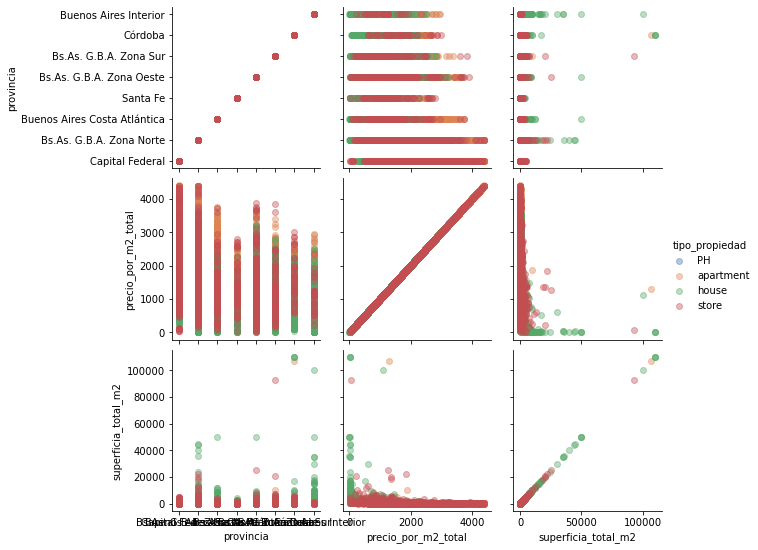

In [57]:
suburb_values = ['PH', 'house', 'apartment', 'store']

data_suburb_mask = data_provincias.tipo_propiedad.apply(lambda x: x in suburb_values)

data_suburb = data_provincias.loc[data_suburb_mask, :]
g = sns.PairGrid(data_suburb, vars=["provincia", "precio_por_m2_total", "superficia_total_m2"],
                 hue='tipo_propiedad', palette='deep')
g.map(plt.scatter, alpha=0.4)
g.add_legend();


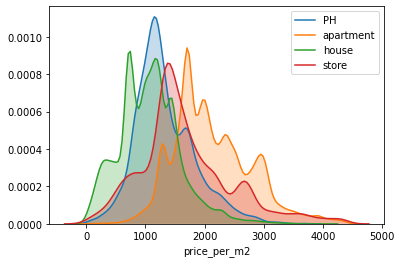

In [58]:
data_newp = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='PH']
data_newa = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='apartment']
data_newh = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='house']
data_news = data_provincias.precio_por_m2_total[data_provincias.tipo_propiedad=='store']
sns.kdeplot(data_newp, label='PH', shade=True)
sns.kdeplot(data_newa, label='apartment', shade=True)
sns.kdeplot(data_newh, label='house', shade=True)
sns.kdeplot(data_news, label='store', shade=True)
plt.xlabel('price_per_m2');

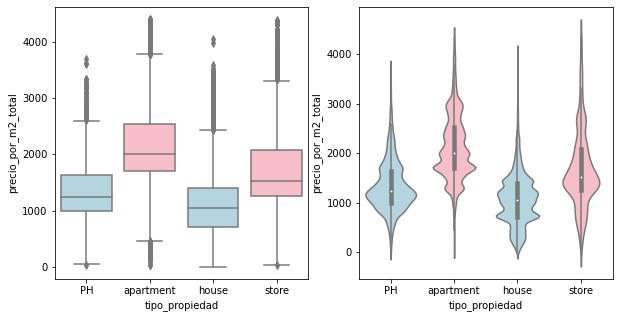

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

sns.boxplot("tipo_propiedad", "precio_por_m2_total", data=data_provincias,
               palette=["lightblue", "lightpink",], ax=axs[0])
sns.violinplot("tipo_propiedad", "precio_por_m2_total", data=data_provincias,
               palette=["lightblue", "lightpink"], ax=axs[1]);

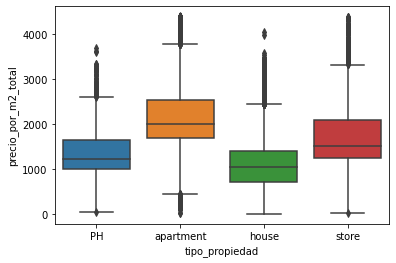

In [60]:
ax = sns.boxplot(x="tipo_propiedad", y="precio_por_m2_total", data=data_provincias)

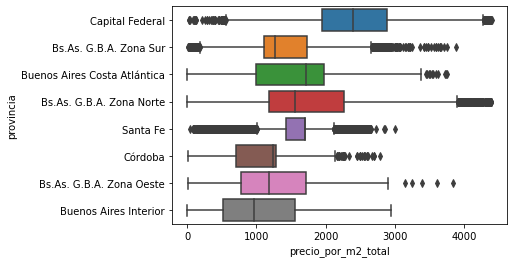

In [61]:
data_ser = data_provincias["provincia"]
ax = sns.boxplot(x="precio_por_m2_total",  y=data_ser, data=data_provincias)

In [62]:
data.head(3)

,id,tipo_propiedad,provincia,lat-lon,superficia_total_m2,superficia_cubierta_m2,precio_por_m2_total,rooms,descripcion,titulo,...,coef_var,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio,fin_propiedad,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,PH,Capital Federal,"-34.6618237,-58.5088387",55.0,40.0,1127.272727,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,...,0.360357,126,0,0,0,0,1,0,0,0
1,1,apartment,Bs.As. G.B.A. Zona Sur,"-34.9038831,-57.9643295",NaN,NaN,1731.810028,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,...,0.256505,1556,0,0,0,0,1,1,0,0
2,2,apartment,Capital Federal,"-34.6522615,-58.5229825",55.0,55.0,1309.090909,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,...,0.297665,144,0,0,0,0,1,1,0,0


## Trabajo 2

#### Visualizaciones
Se intentan generar visualizaciones para observar la relación entre los datos

In [136]:
data_grafico = data.loc[:,['tipo_propiedad','precio_por_m2_total', 'provincia_localidad', 'cantidad_grupo', 'description_pileta', 'description_terraza', 'description_parrilla', 'description_patio','fin_propiedad']]

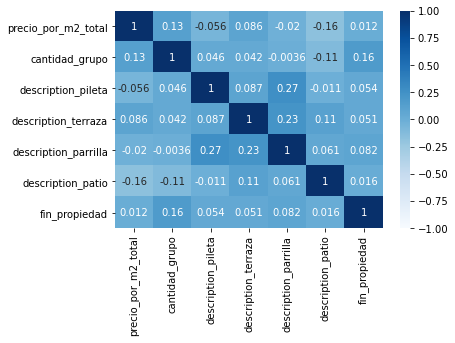

In [137]:
sns.heatmap(data_grafico.corr(), annot=True, vmin=-1, cmap='Blues');


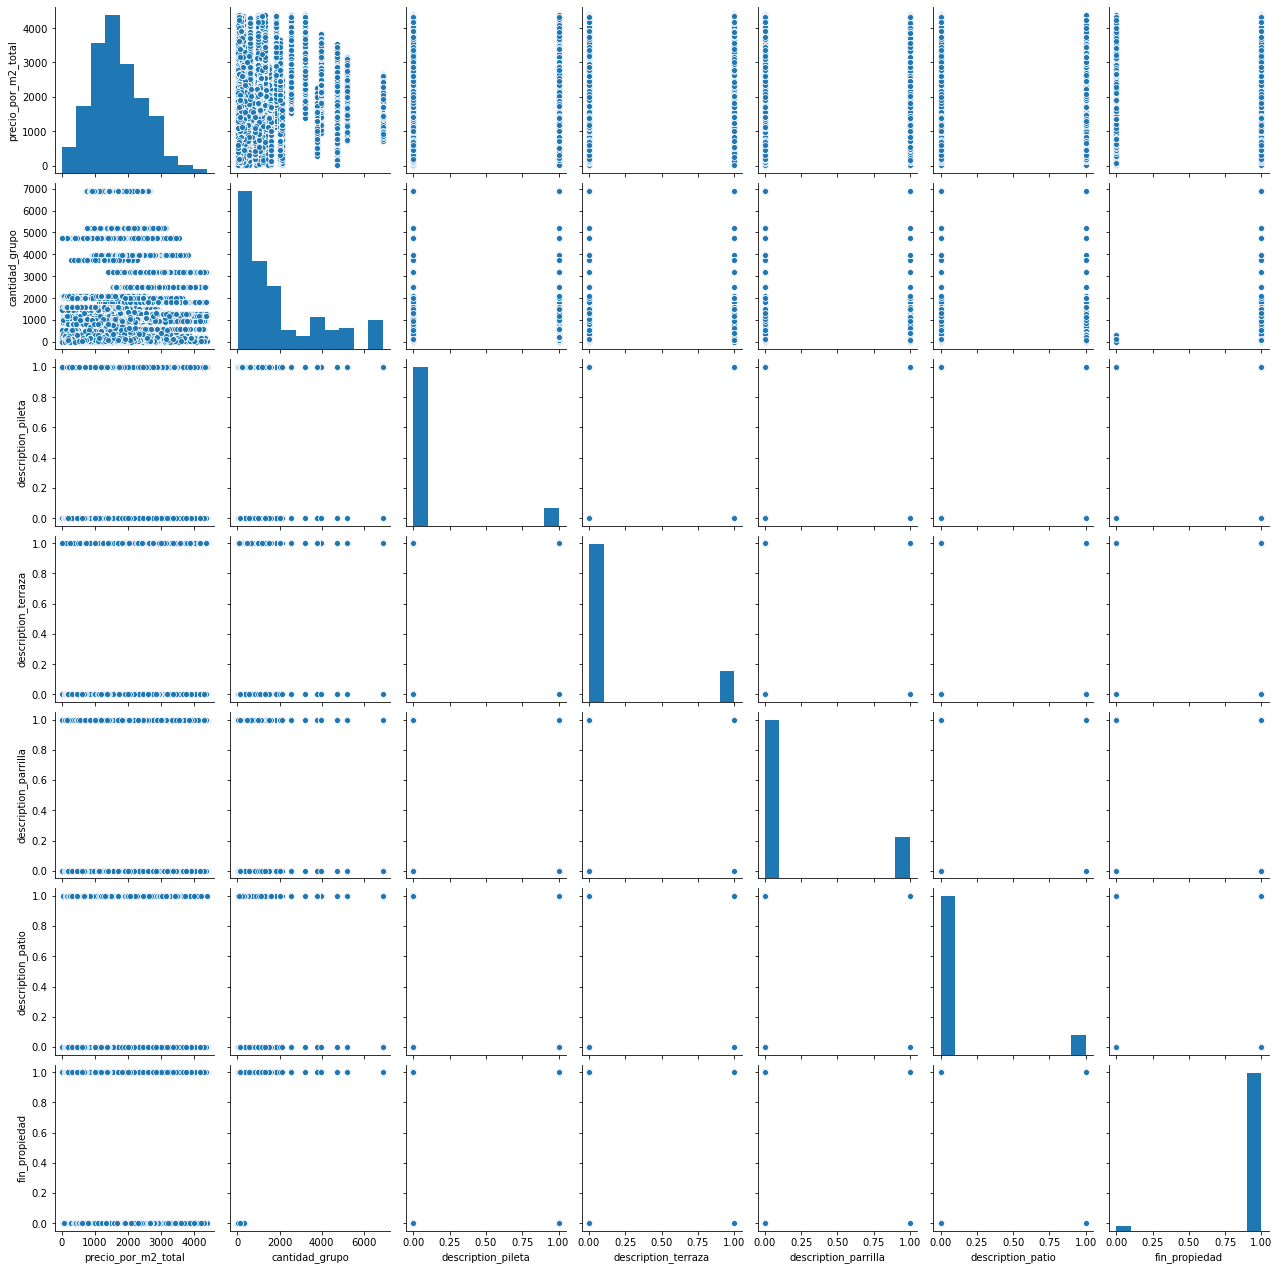

In [138]:
sns.pairplot(data_grafico)


#### Selección de variabes

Se define utilizar la variable **"provincia_localidad"** ya que puede haber **localidades** con el mismo nombre pero de distintas provincias. Dado que esta variable es categórica se convertira en variable dummie.

In [63]:
dummies_localidad=pd.get_dummies(data["provincia_localidad"], drop_first = True)
data_loc= data.join(dummies_localidad)

data_loc.provincia_localidad.describe()

count                             106536
unique                               227
top       Bs.As. G.B.A. Zona Norte_Tigre
freq                                8766
Name: provincia_localidad, dtype: object

Generamos un dataset (data_lr) únicamente con las variables que se utilziaran para el modelo predictivo.

In [64]:
columnas=["id", "tipo_propiedad", "provincia", "lat-lon", "provincia_localidad", "superficia_total_m2","superficia_cubierta_m2", "descripcion","titulo", "barrio", "localidad", "price_m2_prom", "price_m2_desv","coef_var", "cantidad_grupo", "rooms"]
data_lr = data_loc.drop(columnas, axis=1)


In [65]:
data_lr.columns

Index(['precio_por_m2_total', 'description_pileta', 'description_terraza',
       'description_parrilla', 'description_patio', 'fin_propiedad',
       'tipo_propiedad_apartment', 'tipo_propiedad_house',
       'tipo_propiedad_store', 'Bs.As. G.B.A. Zona Norte_General San Martín',
       ...
       'Santa Fe_Roldán', 'Santa Fe_Rosario', 'Santa Fe_San Lorenzo',
       'Santa Fe_Santa Fe', 'Santa Fe_Santo Tomé',
       'Santa Fe_Villa Constitución', 'Tierra Del Fuego_Río Grande',
       'Tucumán_San Miguel de Tucumán', 'Tucumán_Tafí del Valle',
       'Tucumán_Yerba Buena'],
      dtype='object', length=235)

### Modelos predictivos

Para poder generar un modelo de predicción del **precio por m2**, se realizaran diferentes pruebas con distintos modelos y variables para ver cuál tiene mejor rendimiento.

In [66]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Refresión Lineal

En primer lugar se genera una función de Regresión Lineal para realizar pruebas de modeos con distintas variables explicativas. &nbsp;

Se realizará una división entre datos de entrenamiento y datos de testeo, se ajustarán los datos, luego se calculará el R2 en el caso de los datos de testeo y de entrenamiento para analizar el funcionamiento del modelo.
La función tomara como parámetro X(variables explicativas), y(variable a explicar) y test_size(el porcentaje de datos que se utilizaran para test)

In [67]:
def regresion_lineal(X,y, test_size):
    model = LinearRegression()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,test_size=test_size,  random_state=1)
    model.fit(Xtrain, ytrain)
    ypred_train = model.predict(Xtrain)
    print("R2 de train: ", r2_score(ytrain, ypred_train).round(4))
    ypred = model.predict(Xtest)
    print ('R2 de test:', r2_score(ytest, ypred).round(4))
    return model

   

En primer lugar se realizaran modelos ultilizando distintas variables y con test_size de 0.25 que es el valor por default.  &nbsp;

Se genera un modelo de Regresión Lineal Simple utilizando únicamente la variable **provincia_localidad** para observar los resultados.

In [68]:
y1 =data_lr["precio_por_m2_total"]
X1 = data_lr.drop(["precio_por_m2_total", "tipo_propiedad_apartment", "tipo_propiedad_house","tipo_propiedad_store", "fin_propiedad"], axis=1) 
regresion_lineal(X1, y1, 0.25)

R2 de train:  0.5528
R2 de test: 0.5566


LinearRegression()

Se genera un modelo de Regresión Lineal Simple utilizando únicamente la variable **tipo de propiedad**.

In [69]:
y2 =data_lr["precio_por_m2_total"]
X2 = data_lr.loc[:, ["tipo_propiedad_apartment", "tipo_propiedad_house","tipo_propiedad_store"]]
regresion_lineal(X2, y2, 0.25)

R2 de train:  0.3858
R2 de test: 0.3963


LinearRegression()

Se genera un modelo de Regresión Lineal Múltiple utilizando las variables del dataset: **provincia_localidad**(convertida en dummie) y **tipo de propiedad**(convertida en dummie). 

In [70]:
y3 =data_lr["precio_por_m2_total"]
X3 = data_lr.drop(["precio_por_m2_total", "description_pileta", "description_terraza","description_parrilla", "description_patio", "fin_propiedad"], axis=1) 
regresion_lineal(X3, y3, 0.25)

R2 de train:  0.7246
R2 de test: 0.73


LinearRegression()

Se genera un modelo Regresión Lineal Múltiple utilizando todas las variables del dataset: **provincia_localidad**(convertida en dummie), **tipo de propiedad**(convertida en dummie), si cuenta con **pileta**, **parrilla**, **patio** y **terraza** y el **fin de propiedad** (si es residencial o comercial)

In [71]:
y4 =data_lr["precio_por_m2_total"]
X4 = data_lr.drop(["precio_por_m2_total"], axis=1) 
regresion_lineal(X4,y4, 0.25)

R2 de train:  0.7258
R2 de test: 0.731


LinearRegression()

Se genera un modelo Regresión Lineal Múltiple utilizando: **provincia_localidad**(convertida en dummie), **tipo de propiedad**(convertida en dummie) y si cuenta con **pileta**, **parrilla**, **patio** y **terraza**. 
Se quita **fin de propiedad** ya que es una variable construida a partir de **tipo de propiedad** por lo que puede haber colinealidad. Al obtener el mismo resultado de R2 se demuestra que la variable es redundante.

In [72]:
y5 =data_lr["precio_por_m2_total"]
X5 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_lineal(X5, y5, 0.25)

R2 de train:  0.7258
R2 de test: 0.731


LinearRegression()

Se concluye que el mejor modelo es el que incluye las variables **provincia_localidad** (convertida en dummie), **tipo de propiedad** (convertida en dummie)y si cuenta con **pileta**, **parrilla**, **patio** y **terraza**. 


#### Ridge

Dado que el modelo tiene un R2 similar en los datos de entrenamiento y de testeo no se considera que tiene una varianza alta, por el contrario se considera que tiene un problema de segso. &nbsp;

Igualmente, se intentará utilizar regularización a fin de observar si es posible mejorar la performance del modelo.
En primer lugar se genera una función del modelo Ridge con los mismos datos de entrenamiento y testeo que en la Regresión Lineal Múltiple, realizado cross-validation para definir los parametros de *alpha* (100 valores que se definiran como parámetros).

In [73]:
from sklearn import linear_model

In [74]:
def regresion_ridge(X,y, a, b):
    modelo_ridge = linear_model.RidgeCV(alphas=np.linspace(a,b, 100), cv=3, normalize=True)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    modelo_ridge.fit(Xtrain, ytrain)
    ypred_train = modelo_ridge.predict(Xtrain)
    print("R2 de train: ", r2_score(ytrain, ypred_train).round(4))
    ypred = modelo_ridge.predict(Xtest)
    print ('R2 de test:', r2_score(ytest, ypred).round(4))
    print ("alpha:", modelo_ridge.alpha_)    
    return modelo_ridge

Se genera un modelo utilizando las variables **provincia_localidad** (convertida en dummie), **tipo de propiedad**(convertida en dummie) y si cuenta con **pileta**, **parrilla**, **patio** y **terraza** ya que fue el modelo con mejor resultado en la Regresión Lineal Múltiple. Se utilizará el test_size por default que es 0.25. el *alpha* debera ser definido entre 100 valores entre 0.1 y 10.

In [75]:
y_ridge1 =data_lr["precio_por_m2_total"]
X_ridge1 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_ridge(X_ridge1, y_ridge1, 0.1,10)

R2 de train:  0.7209
R2 de test: 0.7259
alpha: 0.1


RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=3, normalize=True)

Se intentará con las mismas variables pero modificando los valores de *alpha* que serán 100 valores entre 0.001 y 0.1.

In [76]:
y_ridge2 =data_lr["precio_por_m2_total"]
X_ridge2 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_ridge(X_ridge2, y_ridge2, 0.001,0.1)

R2 de train:  0.7258
R2 de test: 0.731
alpha: 0.001


RidgeCV(alphas=array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ]),
        cv=3, normalize=True)

Se observa que el modelo con *alpha* 0.1 tiene un R2 levemente inferior a la Regresión Linearl Múliple tanto en los datos de entrenamiento como de testeo. En el caso del modeo con *alpha*=0.001, el R2 es igual al de la Regresión Lineal Múltiple, es decir que el modelo perfoma mejor con *alpha* más bajos, acercandose a la Regresión Lineal Múltiple.

#### Lasso

Se genera una función para modelo Lasso con los mismos datos de entrenamiento y testeo que en la Regresión Lineal Múltiple, realizado cross-validation para definir los parametros de *alpha* (100 valores que se definirán en la función), al igual que en el caso de Ridge.


In [77]:
def regresion_lasso(X,y,a, b):
    modelo_lasso = linear_model.LassoCV(alphas=np.linspace(a,b, 100), cv=3, normalize=True)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    modelo_lasso.fit(Xtrain, ytrain)
    ypred_train = modelo_lasso.predict(Xtrain)
    print("R2 de train: ", r2_score(ytrain, ypred_train).round(4))
    ypred = modelo_lasso.predict(Xtest)
    print ('R2 de test:', r2_score(ytest, ypred).round(4))
    print ("alpha:", modelo_lasso.alpha_)    
    return modelo_lasso


Se genera un modelo utilizando las variables **provincia_localidad** (convertida en dummie), **tipo de propiedad**(convertida en dummie) y si cuenta con **pileta**, **parrilla**, **patio** y **terraza** ya que fue el modelo con mejor resultado en la Regresión Lineal Múltiple. Se utilizará el test_size por default que es 0.25. el *alpha* debera ser definido entre 100 valores entre 0.1 y 10.

In [78]:
y_lasso1 =data_lr["precio_por_m2_total"]
X_lasso1 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_lasso(X_lasso1, y_lasso1, 0.1,10)

R2 de train:  0.6457
R2 de test: 0.6535
alpha: 0.1


LassoCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=3, normalize=True)

Se intentará con las mismas variables pero modificando los valores de *alpha* que serán 100 valores entre 0.001 y 0.1.

In [79]:
y_lasso2 =data_lr["precio_por_m2_total"]
X_lasso2 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_lasso(X_lasso2, y_lasso2, 0.001,0.1)

R2 de train:  0.7258
R2 de test: 0.731
alpha: 0.001


LassoCV(alphas=array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ]),
        cv=3, normalize=True)

Se observa que al igual que en el caso de Ridge, el modelo mejoró su performance al colocar un valor de *alpha* bajo, acercandose al resultado de la Regresión Lineal Múltiple.

#### Elastic Net

Se genera una función para intentar generar un modelo Elastic Net que combine Lasso y Ridge. En este caso se incorporá a los argumentos de la función los hiperparámetros del modelo (alpha y l1_ratio)

In [80]:
#por default: l1_ratio=0.5

def regresion_elastic(X,y, alpha, l1_ratio):
    elastic_net = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio, normalize=True)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    elastic_net.fit(Xtrain, ytrain)
    ypred_train = elastic_net.predict(Xtrain)
    print("R2 de train: ", r2_score(ytrain, ypred_train).round(3))
    ypred = elastic_net.predict(Xtest)
    print ('R2 de test:', r2_score(ytest, ypred).round(3))
    return elastic_net

Se genera un modelo utilizando las variables **provincia_localidad** (convertida en dummie), **tipo de propiedad** (convertida en dummie) y si cuenta con **pileta**, **parrilla**, **patio** y **terraza**. Se utiliza un *alpha* = 0.001 ya que fue el valor que mejor performó en Ridge y Lasso y *l1_ratio*=0.5 (valor por default).

In [81]:
y_elastic1 =data_lr["precio_por_m2_total"]
X_elastic1 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_elastic(X_elastic1, y_elastic1, alpha=0.001, l1_ratio=0.5)

R2 de train:  0.059
R2 de test: 0.06


ElasticNet(alpha=0.001, normalize=True)

Se puede observar que el R2 es muy bajo. Se genera otro modelo igual al anterior pero con *l1_ratio*=0.9

In [82]:
y_elastic2 =data_lr["precio_por_m2_total"]
X_elastic2 = data_lr.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_elastic(X_elastic2, y_elastic2, alpha=0.001, l1_ratio=0.9)

R2 de train:  0.231
R2 de test: 0.233


ElasticNet(alpha=0.001, l1_ratio=0.9, normalize=True)

Se obervan resultado muy inferiores de R2 que en los modelos anteriores.

##### Conclusión

Dado que el modelo con mejor rendimiento es el de Regresión Lineal Múltiple se confirma que no hay un problema de alta **varianza**, sino que hay un problema de **sesgo**, por lo que es necesario complejizar el modelo.

#### Modelo regresión cuadrática

Se intentará complejizar el modelo a traves de una Regresión Cuadrática.  &nbsp;

Sería interesante elevar las variables explicativas al cuadrado pero las variables son dummies, por lo que al elevar 0 y 1 al cuadrado, no se realiza ninguna modificación.

In [87]:
y_cuad2 =data_lr["precio_por_m2_total"]
X_cuad2 = data_lr.drop(["fin_propiedad", "precio_2", "precio_por_m2_total", "precio_3"], axis=1)**2
regresion_lineal(X_cuad2, y_cuad2, 0.25)

R2 de train:  0.7258
R2 de test: 0.731


LinearRegression()

Por lo tanto se intentará considerar los valores de **precio por m2 total** al cuadrado.

In [83]:
data_lr["precio_2"]=data_lr["precio_por_m2_total"]**2

In [84]:
y_cuad1 =data_lr["precio_2"]
X_cuad1 = data_lr.drop(["fin_propiedad","precio_2", "precio_por_m2_total"], axis=1) 
regresion_lineal(X_cuad1, y_cuad1, 0.25)

R2 de train:  0.6731
R2 de test: 0.6807


LinearRegression()

Se intentará elevando el **precio por m2 total** al cubo.

In [85]:
data_lr["precio_3"]=data_lr["precio_por_m2_total"]**3


In [86]:
y_cubo =data_lr["precio_3"]
X_cubo = data_lr.drop(["fin_propiedad", "precio_2", "precio_3", "precio_por_m2_total"], axis=1)
regresion_lineal(X_cubo, y_cubo, 0.25)

R2 de train:  0.5842
R2 de test: 0.5952


LinearRegression()

Como conclusión el modelo con el precio al cuadrado o al cubo performa peor que los modelos generados previamente. Asimismo no es posible hacer al cuadrado las variables explicativas, por lo que no es posible realizar una Regresión cuadrática.

#### Agregar Variables

Dado que el problema es el **sesgo**, una posibe solución es incorporar variables. &nbsp;

En primer lugar se intentará analizar si la propiedad cuenta con **cochera**, **lavadero** y **balcon**. Para esto se utiliza el dataset antes de dropear las columnas que no se utilizarían para el modelo a fin de realiar la búsqueda a través de la columna **descripción**.

In [88]:
def buscar_amenities(patron):
    patron_amenities = patron
    regex =re.compile(patron_amenities)
    tiene_amenities = data_loc["descripcion"].apply(lambda x: None if x is np.NaN else regex.search(x))
    amenities = tiene_amenities.apply(lambda x: x if x is None else x.group(0))
    dummie_amenities = amenities.apply(lambda x :0 if x is None else 1)
    return dummie_amenities

In [89]:
cochera = buscar_amenities("cochera")
lavadero = buscar_amenities("lavadero")
balcon = buscar_amenities("balcon")
data_loc=data_loc.join(cochera, rsuffix="_cochera")
data_loc=data_loc.join(lavadero, rsuffix="_lavadero")
data_loc=data_loc.join(balcon, rsuffix="_balcon")

Nuevamente se genera un dataset solo con las variables que se utilizarán:

In [90]:
columnas=['id', 'tipo_propiedad', 'provincia', 'lat-lon', 'superficia_total_m2','superficia_cubierta_m2', "provincia_localidad",'descripcion','titulo', 'barrio', 'localidad', 'price_m2_prom', 'price_m2_desv','coef_var']
data_test = data_loc.drop(columnas, axis=1)


In [91]:
data_test.head(3)

,precio_por_m2_total,rooms,cantidad_grupo,description_pileta,description_terraza,description_parrilla,description_patio,fin_propiedad,tipo_propiedad_apartment,tipo_propiedad_house,...,Santa Fe_Santa Fe,Santa Fe_Santo Tomé,Santa Fe_Villa Constitución,Tierra Del Fuego_Río Grande,Tucumán_San Miguel de Tucumán,Tucumán_Tafí del Valle,Tucumán_Yerba Buena,descripcion_cochera,descripcion_lavadero,descripcion_balcon
0,1127.272727,NaN,126,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1731.810028,NaN,1556,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1309.090909,NaN,144,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Se genera un modelo de Regresión Lineal Múltiple utilizando las variables  **provincia_localidad** (convertida en dummie), **tipo de propiedad** (convertida en dummie) y si cuenta con **pileta**, **parrilla**, **patio**, **terraza**, **balcon**, **cochera** y **lavadero**.

In [92]:
y_amen =data_test["precio_por_m2_total"]
X_amen = data_test.drop(["fin_propiedad", "cantidad_grupo", "precio_por_m2_total", "rooms"], axis=1)
regresion_lineal(X_amen, y_amen, 0.25)


R2 de train:  0.7268
R2 de test: 0.7317


LinearRegression()

##### Oferta de propiedades
Analizando que es posible que la oferta de propidades pueda tener influencia en el precio de las mismas, se incluye la variable **cantidad_grupo** que se refiere a la cantidad de publicaciones por **tipo de propiedad** por **provincia_localidad**.

In [93]:
y_amen2 =data_test["precio_por_m2_total"]
X_amen2 = data_test.drop(["precio_por_m2_total", "fin_propiedad", "rooms"], axis=1) 
regresion_lineal(X_amen2, y_amen2, 0.25)

R2 de train:  0.7268
R2 de test: 0.7318


LinearRegression()

En este caso el nuevo modelo tiene un R2 levemente mejor pero sigue existiendo el problema del sesgo.

##### Cantidad de Ambientes



Se intentá completar la variable **rooms** que había sido de lado por tener muchos datos nulos a fin de poder inlcuirla como variable explicativa. Se realiza a través de búsqueda con expresiones regulares.

In [94]:
#Extraigo ambientes de descripción   
def get_ambientes(s, nombre_hab):
    palabras = {'mono':1, 'dos':2, 'tres':3, 'cuatro':4, 'cinco':5, 'seis':6,'unico':1,'único':1}
    if pd.isnull(s):
        return np.nan
    match = re.search(r'\b([\d\w]+?)\s?' + nombre_hab, s, flags = re.IGNORECASE)    
    if match is None:
        return None
    elif match.group(1).isdigit():
        return int(match.group(1))
    else:
        for p in palabras.keys():
            if p in match.group(1).lower():
                return palabras[p]

In [95]:
data_loc['amb_desc'] = data_loc['descripcion'].apply(lambda x:get_ambientes(x,'amb'))
data_loc['dorm_desc'] = data_loc['descripcion'].apply(lambda x:get_ambientes(x,'dorm'))
data_loc['hab_desc'] = data_loc['descripcion'].apply(lambda x:get_ambientes(x,'hab'))
data_loc['rooms'].isnull().sum()

63949

In [96]:
data_loc['rooms'].fillna(data_loc['amb_desc'],inplace=True)
data_loc['rooms'].fillna(data_loc['dorm_desc'] +1,inplace=True)
data_loc['rooms'].fillna(data_loc['hab_desc'] +1,inplace=True)
data_loc['rooms'].isnull().sum()

18414

In [141]:
data_loc['rooms'].isnull().sum()/data_loc.shape[0]*100

17.284298265375085

Luego de la imputación sigue habiendo 18.414 datos (17.28%) nulos. Se realizará un modelo de Reresión Lineal Múltiple utilizando esta variable, quitando del dataset los datos nulos.

In [97]:
columnas=['id', 'tipo_propiedad', 'provincia', 'lat-lon', 'superficia_total_m2','superficia_cubierta_m2', "provincia_localidad",'descripcion','titulo', 'barrio', 'localidad', 'price_m2_prom', 'price_m2_desv','coef_var', 'amb_desc', 'dorm_desc', 'hab_desc']
data_test_2 = data_loc.drop(columnas, axis=1)


In [98]:
data_test_3=data_test_2.loc[data_loc['rooms'].notnull()]

In [99]:
y_amb =data_test_3["precio_por_m2_total"]
X_amb = data_test_3.drop(["precio_por_m2_total", "fin_propiedad"], axis=1) 
regresion_lineal(X_amb, y_amb, 0.25)

R2 de train:  0.7466
R2 de test: 0.7421


LinearRegression()

Se observa una leve mejora del modelo pero se considera que no es lo suficientemente significativa. Dado que implica quitar el 17.28% de los registros, se define no utilizarla.

#### AMBA

Se intenta realizar el modelo utilizando unicamente las el Área Metropolitana de Buenos Aires: **"Bs.As. G.B.A. Zona Norte"**, **"Bs.As. G.B.A. Zona Oeste"**, **"Bs.As. G.B.A. Zona Sur"** y **"Capital Federal"**

In [100]:
#Se filtran el dataset
prov = data_loc["provincia"]    
mask = (prov =="Bs.As. G.B.A. Zona Norte") |(prov =="Bs.As. G.B.A. Zona Oeste")|(prov =="Bs.As. G.B.A. Zona Sur") |(prov =="Capital Federal") 
data_amba = data_loc.loc[mask, :]


In [101]:
#Se crea el dataset para elmodelo de regresión
columnas=['id', 'tipo_propiedad', 'provincia', 'lat-lon', "provincia_localidad", 'superficia_total_m2','superficia_cubierta_m2', 'descripcion','titulo', 'barrio', 'localidad', 'price_m2_prom', 'price_m2_desv','coef_var', "rooms", "amb_desc", "dorm_desc", "hab_desc"]
data_amba_lr = data_amba.drop(columnas, axis=1)


In [102]:
y_amba =data_amba_lr["precio_por_m2_total"]
X_amba = data_amba_lr.drop(["fin_propiedad", "precio_por_m2_total"], axis=1)
regresion_lineal(X_amba, y_amba, 0.25)

R2 de train:  0.7061
R2 de test: 0.7025


LinearRegression()

#### Capital Federal

Se intentará llevar a cabo del modelo únicamente con *Capital Federal*.

In [103]:
#Se filtran los datos de Capital Federal
mask = data_loc["provincia"]=="Capital Federal"
data_cap = data_loc.loc[mask, :]

#Se genera el dataset para el modelo de regresión
columnas=['id', 'tipo_propiedad', 'provincia', 'lat-lon', "provincia_localidad", 'superficia_total_m2','superficia_cubierta_m2', 'descripcion','titulo', 'barrio', 'localidad', 'price_m2_prom', 'price_m2_desv','coef_var', "rooms", "amb_desc", "dorm_desc", "hab_desc"]
data_cap_lr = data_cap.drop(columnas, axis=1)


In [104]:
y_caba =data_cap_lr["precio_por_m2_total"]
X_caba = data_cap_lr.drop(["fin_propiedad", "precio_por_m2_total"], axis=1)
regresion_lineal(X_caba, y_caba, 0.25)

R2 de train:  0.598
R2 de test: 0.6044


LinearRegression()

Se concluye que utilizando solamente los datos de Capital Federal o de AMBA el rendimiento del modelo empeora,  por lo que se define realizar el modelo con la totalidad de los datos del dataset.

#### Confirmar métricas

##### Cross Validation

Para asegurarnos estar midiendo correctamente la performance, se realiza un método de cross-validation para observar la capacidad de predecir del modelo.

In [105]:
from sklearn.model_selection import cross_val_score


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_amen2, y_amen2, random_state=1)

In [110]:
cross_score = cross_val_score(estimator=LinearRegression(), X=X_train, y=y_train, cv=15, scoring="r2")
cross_score

array([0.71311125, 0.71990469, 0.72912576, 0.72240407, 0.72518332,
       0.73072697, 0.72005569, 0.72893733, 0.73545699, 0.71636427,
       0.72559451, 0.73103702, 0.72711885, 0.73418127, 0.72149123])

In [111]:
print(cross_score.mean())
print(cross_score.std())

0.7253795471344783
0.006237015503772445


El resultado es similar al que obteniamos midiendo el R2.

##### Datos de entrenamiento y testeo
Se generan modelos modificando la cantidad de datos de entrenamiento y testeo para observar si hay modificaciones en los resultados y comprobar que se realiza correctamente la operación.

In [112]:
y_1 =data_test["precio_por_m2_total"]
X_1 = data_test.drop(["precio_por_m2_total", "fin_propiedad", "rooms"], axis=1) 
regresion_lineal(X_1, y_1, 0.15)

R2 de train:  0.7274
R2 de test: 0.7321


LinearRegression()

In [113]:
y_2 =data_test["precio_por_m2_total"]
X_2 = data_test.drop(["precio_por_m2_total", "fin_propiedad", "rooms"], axis=1) 
regresion_lineal(X_2, y_2, 0.3)

R2 de train:  0.7277
R2 de test: 0.7288


LinearRegression()

In [114]:
y_3 =data_test["precio_por_m2_total"]
X_3 = data_test.drop(["precio_por_m2_total", "fin_propiedad", "rooms"], axis=1) 
regresion_lineal(X_3, y_3, 0.5)

R2 de train:  0.7289
R2 de test: 0.7263


LinearRegression()

Se puede observar que variando el porcentaje de datos de entrenamiento y testeo, los resultados de R2 son similares.

### Conclusión

El modelo que tiene un mejor rendimiento es el de Regresión Lineal Múltiple con las variables **provincia_localidad** (convertida en dummie), **tipo de propiedad** (convertida en dummie), **cantidad_grupo** y si cuenta con **pileta**, **parrilla**, **patio**, **terraza**, **balcon**, **cochera** y **lavadero**.

In [115]:
y =data_test["precio_por_m2_total"]
X = data_test.drop(["precio_por_m2_total", "fin_propiedad", "rooms"], axis=1) 
regresion_lineal(X, y, 0.25)

R2 de train:  0.7268
R2 de test: 0.7318


LinearRegression()